## TensorFlow and Keras
- Installing TensorFlow
- Loading images

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
from tensorflow.keras.preprocessing.image import load_img

In [4]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
full_name = path + '/' + name

In [5]:
# NN model can only accpet image size at 299*299, 224*224, 150*150
img = load_img(full_name, target_size = (299, 299))
# Each image contains three channels: red, green, blue
# The number range of each pixel in each channel is 0-255
# The pixel is each image is composed by (R, G, B)

In [6]:
# Convert img to numpy array (150 rows * 150 columns)
x = np.array(img)
x.shape

(299, 299, 3)

## Pre-trained convolutional neural networks
- Imagenet dataset: https://www.image-net.org/
- Pre-trained models: https://keras.io/api/applications/

In [5]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.applications.xception import decode_predictions

In [8]:
model = Xception(weights='imagenet', input_shape=(299,299,3))

In [9]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [10]:
X = preprocess_input(X)

In [37]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [38]:
pred.shape

(1, 1000)

In [40]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


[[('n03595614', 'jersey', 0.6792447),
  ('n02916936', 'bulletproof_vest', 0.03960033),
  ('n04370456', 'sweatshirt', 0.035299614),
  ('n03710637', 'maillot', 0.010884147),
  ('n04525038', 'velvet', 0.0018057636)]]

## Convolutional neural networks
- Types of layers: convolutional and dense
- Convolutional layers and filters
- Dense layers

In [ ]:
# Convolution Layer
# Each filter generate one feature map
# Each convolutional layer contains n feature maps (n=number of filters)
# The filters in next layer are combinations of the filters from previous layers.

In [ ]:
# Vector Representation
# 将所有从convolution layer处理后的数据转换成vector

In [ ]:
# Dense Layer
# 假设这是classification的问题
# 每个output对应着一种结果，并自带一组weights
# vector需要跟每组weights进行计算, 在经过soft max layer得出最终结果
# soft max = sigmoid for multiple classes

In [ ]:
# Pooling Layer
# Shrink the size of convolution layer

## Transfer learning
- Reading data with ImageDataGenerator
- Train Xception on smaller images (150x150)

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [7]:
# image_dataset_from_directory可以自动解析feature values and target values
train_gen = image_dataset_from_directory('./clothing-dataset-small/train', 
                             image_size=(150, 150), # the size of images
                             batch_size=32) # the number of images

val_gen = image_dataset_from_directory('./clothing-dataset-small/validation',
                                      image_size=(150,150),
                                      batch_size=32, shuffle=False)

Found 3068 files belonging to 10 classes.
Found 341 files belonging to 10 classes.


In [190]:
train_gen.class_names

['dress',
 'hat',
 'longsleeve',
 'outwear',
 'pants',
 'shirt',
 'shoes',
 'shorts',
 'skirt',
 't-shirt']

In [8]:
preprocessing_layer = keras.layers.Lambda(preprocess_input)

In [9]:
# Add preprocessing layer to standardize data
preprocessing_layer = keras.layers.Lambda(preprocess_input)

AUTOTUNE = tf.data.AUTOTUNE
# map() process batches for each time
train_ds = train_gen.map(lambda x, y: (preprocessing_layer(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_gen.map(lambda x, y: (preprocessing_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# X包含32张图片，每张大小150 * 150，且每一张含有3个channels
# y为图片所在folder的folder index (e.g. 1,2,3)
X,y = train_gen \
.map(lambda x, y: (preprocess_input(x),y)) \
.as_numpy_iterator() \
.next()

2025-02-16 22:00:13.441779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3068]
	 [[{{node Placeholder/_4}}]]
2025-02-16 22:00:13.442588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3068]
	 [[{{node Placeholder/_0}}]]


In [11]:
X.shape

(32, 150, 150, 3)

In [192]:
y[:5]

array([0, 9, 5, 5, 0], dtype=int32)

### Neural Network Architecture
- Image: raw data
- Convolutional layer: base model
- Vector representation and Pooling
- Dense layer: custom model
- Multi-class prediction

### Convolutional Layer

In [193]:
# Xception is a full neural network model, including convolutional layer and dense layer.
# In this case, we build the convolution layer
base_model = Xception(weights='imagenet',
                     include_top=False, # only use convolutional layer
                     input_shape=(150,150,3))

base_model.trainable=False # freeze convolutional layer (don't train)

### Logic for Vector Representation and Pooling
- The process of reducing 3-D array to 1-D array is called Pooling
- In this case, we apply average pooling on 3-D array, calculating the average of each 5 * 5 array and storing the result in the new 1-D array 

In [194]:
# X
inputs = keras.Input(shape=(150,150,3)) 

# 3-D array
base = base_model(inputs) 

# Pooling (reduce dimensionality) and Vectorizing
pooling = keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)

# Transformed X
outputs = vectors

# Consolidation: grouping layers into a model
model = keras.Model(inputs, outputs)

In [195]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


### Before Pooling
#### the shape of array - (32,5,5,2048)
- 32: batch size
- 5 * 5: filter size
- 2048: the number of feature maps

### After Pooling
#### the shape of array - (32, 2048)

In [131]:
pred.shape

(32, 2048)

### Dense Layer: Simple Version

In [196]:
# X
inputs = keras.Input(shape=(150,150,3)) 

# Convolution Layer, return 3-D array
base = base_model(inputs, training=False) 

# Pooling (reduce dimensionality) and Vectorizing, return 1-D array
vectors = keras.layers.GlobalAveragePooling2D()(base)

# Dense Layer, return predictions for 10 classes
outputs = keras.layers.Dense(10)(vectors)

# Consolidation: grouping layers into a model
model = keras.Model(inputs, outputs)

# Prediction
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [137]:
pred.shape

(32, 10)

### Optimizer
- Adjust weights in terms of error sent by Losses
- Use for finding the best weights in dense layer

### Losses
- compare differences between prediction and target
- send error back to dense layer

In [197]:
learning_rate=0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Multi-class: CategoricalCrossentropy
# Binary-class: BinaryCrossentropy
# Linear Regression: MeanSquaredError

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
# from_logits = True, return row score without using activation method
# otherwise, from_logits = False, return probabilities calculating by activation method
# Example (from_logits=false): outputs = keras.layers.Dense(10, activation='softmax')(vectors)

# Compile optimizer and loss before training the model
model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

In [198]:
history = model.fit(train_gen, 
          epochs=10, # how many times to iterator the whole dataset
          validation_data=val_gen
         )

Epoch 1/10
 9/96 ━━━━━━━━━━━━━━━━━━━━ 1:11 823ms/step - accuracy: 0.1598 - loss: 45.8501

KeyboardInterrupt: 

### Dense Layer
- After calculating vector and weights, we have outputs from dense layer called "raw output"
- Transfer raw output to Activation method (softmax) to predict probabilities to classes

## Adjust Learning Rate
- What's the learning rate 
- Try different values

In [50]:
def make_model(learning_rate=0.01):
    base_model=Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150,150,3)
    )

    base_model.trainable=False

    inputs = keras.Input(shape=(150,150,3))

    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    outputs = keras.layers.Dense(10)(vectors)

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    model.compile(optimizer=optimizer, loss = loss, metrics = ['accuracy'])

    return model

In [51]:
scores={}
for lr in [0.0001, 0.001, 0.01, 0.1]:

    model = make_model(lr)
    
    history = model.fit(train_ds, 
          epochs=10, # how many times to iterator the whole dataset
          validation_data=val_ds
         )
    print(lr)
    
    scores[lr]=history.history

    print(''.join(['-']*15))

Epoch 1/10
96/96 [==============================] - 104s 1s/step - loss: 1.8542 - accuracy: 0.3879 - val_loss: 1.5296 - val_accuracy: 0.5220
Epoch 2/10
96/96 [==============================] - 97s 1s/step - loss: 1.3484 - accuracy: 0.5730 - val_loss: 1.2069 - val_accuracy: 0.6158
Epoch 3/10
96/96 [==============================] - 97s 1s/step - loss: 1.1187 - accuracy: 0.6473 - val_loss: 1.0344 - val_accuracy: 0.6686
Epoch 4/10
96/96 [==============================] - 96s 998ms/step - loss: 0.9838 - accuracy: 0.6864 - val_loss: 0.9401 - val_accuracy: 0.7097
Epoch 5/10
96/96 [==============================] - 97s 1s/step - loss: 0.8954 - accuracy: 0.7161 - val_loss: 0.8733 - val_accuracy: 0.7214
Epoch 6/10
96/96 [==============================] - 97s 1s/step - loss: 0.8308 - accuracy: 0.7376 - val_loss: 0.8220 - val_accuracy: 0.7507
Epoch 7/10
96/96 [==============================] - 96s 1s/step - loss: 0.7801 - accuracy: 0.7500 - val_loss: 0.7840 - val_accuracy: 0.7713
Epoch 8/10
96/96

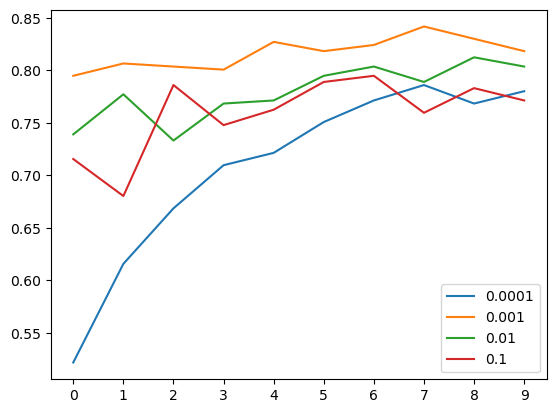

In [53]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)
    
plt.xticks(np.arange(10))
plt.legend()

In [ ]:
learning_rate=0.001

## Checkpointing
- Saving the best model only
- Training a model with callbacks

In [15]:
model.save_weights('model_v1.weights.h5', overwrite=True)

In [30]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True, #Only save model with best performance
    monitor='val_accuracy', # Define metrics to evaluate model performance
    mode = 'max' # Find the model with the highest val_accuracy
)

In [214]:
# epoch=3
# val_accuracy=0.84
# f'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5'

'xception_v1_03_0.840.h5'

In [31]:
learning_rate = 0.001

model = make_model(learning_rate)

history = model.fit(train_gen,
                    epochs=10,
                    validation_data=val_gen,
                    callbacks=[checkpoint])

Epoch 1/10


2025-02-15 16:49:58.461804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3068]
	 [[{{node Placeholder/_4}}]]
2025-02-15 16:49:58.462232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3068]
	 [[{{node Placeholder/_4}}]]


96/96 [==============================] - ETA: 0s - loss: 7.5938 - accuracy: 0.2467   

2025-02-15 16:51:39.830210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [341]
	 [[{{node Placeholder/_4}}]]
2025-02-15 16:51:39.830902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [341]
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - 113s 1s/step - loss: 7.5938 - accuracy: 0.2467 - val_loss: 4.6656 - val_accuracy: 0.3138
Epoch 2/10
96/96 [==============================] - 100s 1s/step - loss: 3.9400 - accuracy: 0.3556 - val_loss: 4.5824 - val_accuracy: 0.2903
Epoch 3/10
96/96 [==============================] - 116s 1s/step - loss: 3.3309 - accuracy: 0.4048 - val_loss: 3.3172 - val_accuracy: 0.3812
Epoch 4/10
96/96 [==============================] - 113s 1s/step - loss: 2.9740 - accuracy: 0.4351 - val_loss: 3.3001 - val_accuracy: 0.3959
Epoch 5/10
96/96 [==============================] - 105s 1s/step - loss: 2.5098 - accuracy: 0.4703 - val_loss: 3.6444 - val_accuracy: 0.3372
Epoch 6/10
96/96 [==============================] - 113s 1s/step - loss: 2.1926 - accuracy: 0.5036 - val_loss: 3.2377 - val_accuracy: 0.3812
Epoch 7/10
96/96 [==============================] - 109s 1s/step - loss: 1.9580 - accuracy: 0.5261 - val_loss: 3.1011 - val_accuracy: 0.3724
Epoch 8/10
96/96 [======

## Adding more layers
- Adding one inner dense layer
- Experimenting with different sizes of inner layer

In [54]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model=Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150,150,3)
    )
    # Convolutional Layer
    base_model.trainable=False

    inputs = keras.Input(shape=(150,150,3))

    base = base_model(inputs, training=False)

    # Vector and Pooling Layer
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    # Dense Layer
    inner = keras.layers.Dense(size_inner, activation = 'relu')(vectors) # relu is a activation method for inner dense layer
    outputs = keras.layers.Dense(10)(inner)

    # Compile Model
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    model.compile(optimizer=optimizer, loss = loss, metrics = ['accuracy'])

    return model 

In [57]:
scores={}
learning_rate = 0.001
for size in [10,100,1000]:

    model = make_model(learning_rate, size)
    
    history = model.fit(train_ds, 
          epochs=10, # how many times to iterator the whole dataset
          validation_data=val_ds
         )
    print(size)
    
    scores[size]=history.history

    print(''.join(['-']*15))

Epoch 1/10
96/96 [==============================] - 92s 929ms/step - loss: 1.3764 - accuracy: 0.5476 - val_loss: 0.9812 - val_accuracy: 0.7243
Epoch 2/10
96/96 [==============================] - 83s 866ms/step - loss: 0.8369 - accuracy: 0.7259 - val_loss: 0.8110 - val_accuracy: 0.7243
Epoch 3/10
96/96 [==============================] - 81s 843ms/step - loss: 0.6250 - accuracy: 0.7924 - val_loss: 0.6679 - val_accuracy: 0.7713
Epoch 4/10
96/96 [==============================] - 78s 811ms/step - loss: 0.4991 - accuracy: 0.8383 - val_loss: 0.6189 - val_accuracy: 0.7918
Epoch 5/10
96/96 [==============================] - 76s 796ms/step - loss: 0.4282 - accuracy: 0.8625 - val_loss: 0.6173 - val_accuracy: 0.7918
Epoch 6/10
96/96 [==============================] - 77s 807ms/step - loss: 0.3596 - accuracy: 0.8875 - val_loss: 0.5894 - val_accuracy: 0.8065
Epoch 7/10
96/96 [==============================] - 78s 810ms/step - loss: 0.3150 - accuracy: 0.9012 - val_loss: 0.5832 - val_accuracy: 0.8182

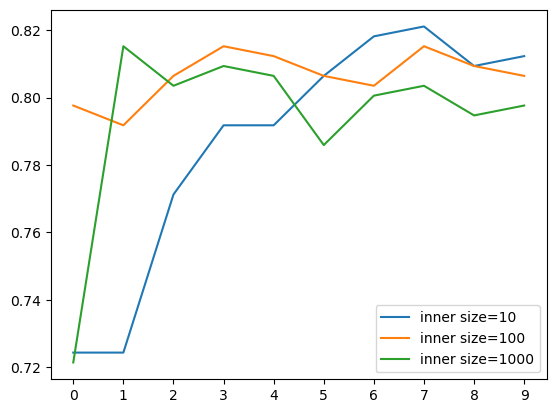

In [59]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label = f'inner size={size}')

plt.xticks(np.arange(10))
plt.legend()

## Regularization and dropout
- Regularizing by freezing a part of the network
- Adding dropout to our model
- Experimenting with different values

In [ ]:
# Dropout can be understood as hiding a part of image
# This method forces NN model to learn and identify data (images) in a bigger image - ignore outliers

In [60]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model=Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150,150,3)
    )
    # Convolutional Layer
    base_model.trainable=False

    inputs = keras.Input(shape=(150,150,3))

    base = base_model(inputs, training=False)

    # Vector and Pooling Layer
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    # Dense Layer
    ## Inner 
    inner = keras.layers.Dense(size_inner, activation = 'relu')(vectors) # relu is a activation method for inner dense layer
    ## Dropout
    ### dropout = freeze partial neuros in inner dense layer
    ### drop rate determines how many neuros (%) to be frozen
    drop = keras.layers.Dropout(droprate)(inner)
    # Output
    outputs = keras.layers.Dense(10)(drop)

    # Compile Model
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    model.compile(optimizer=optimizer, loss = loss, metrics = ['accuracy'])

    return model 

In [62]:
scores={}
learning_rate = 0.001
size = 100
for droprate in [0.0,0.2,0.5,0.8]:

    model = make_model(learning_rate, size, droprate)
    print(droprate)
    history = model.fit(train_ds, 
          epochs=30, # how many times to iterator the whole dataset
          validation_data=val_ds
         )
    
    scores[size]=history.history

    print(''.join(['-']*15))

0.0
Epoch 1/30
96/96 [==============================] - 93s 937ms/step - loss: 0.9652 - accuracy: 0.6783 - val_loss: 0.6354 - val_accuracy: 0.7830
Epoch 2/30
96/96 [==============================] - 88s 919ms/step - loss: 0.4896 - accuracy: 0.8230 - val_loss: 0.5635 - val_accuracy: 0.8065
Epoch 3/30
96/96 [==============================] - 91s 948ms/step - loss: 0.3341 - accuracy: 0.8895 - val_loss: 0.5602 - val_accuracy: 0.8270
Epoch 4/30
96/96 [==============================] - 93s 970ms/step - loss: 0.2425 - accuracy: 0.9198 - val_loss: 0.5486 - val_accuracy: 0.8240
Epoch 5/30
96/96 [==============================] - 94s 980ms/step - loss: 0.1691 - accuracy: 0.9531 - val_loss: 0.6032 - val_accuracy: 0.8299
Epoch 6/30
96/96 [==============================] - 98s 1s/step - loss: 0.1092 - accuracy: 0.9759 - val_loss: 0.5699 - val_accuracy: 0.8211
Epoch 7/30
96/96 [==============================] - 96s 1s/step - loss: 0.0770 - accuracy: 0.9889 - val_loss: 0.6133 - val_accuracy: 0.8240
E

KeyboardInterrupt: 

In [ ]:
# learning rate = 0.001
# size = 100
# droprate = 0.2

## Data augmentation
- Different data augmentations
- Training a model with augmentations
- How to select data augmentations?

### Data augmentation有几种方法：
1. flip：上下左右翻动
2. rotation: 360度旋转
3. shift: 左右平移和上下平移
4. shear：拉扯image的四个角，使图片变形
5. zoom: 按长宽zoom in and zoom out
6. brightness and contrast
7. dropout

### When need data augmentations?
- Any variance in images
- Train data with data augmentation in 10-20 epochs. Good performance, use it. Same or worse performance, dont use it

In [1]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

2025-02-16 20:10:44.197355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_gen = image_dataset_from_directory('./clothing-dataset-small/train', 
                             image_size=(150, 150), # the size of images
                             batch_size=32) # the number of images

val_gen = image_dataset_from_directory('./clothing-dataset-small/validation',
                                      image_size=(150,150),
                                      batch_size=32,shuffle=False)

Found 3068 files belonging to 10 classes.
Found 341 files belonging to 10 classes.


In [9]:
# Add preprocessing layer to standardize data
preprocessing_layer = keras.layers.Lambda(preprocess_input)

data_augmentation = keras.Sequential([
    keras.layers.Lambda(preprocess_input),
    keras.layers.RandomFlip("vertical"), # 以垂直线为中轴线翻转
    # keras.layers.RandomRotation(0.1667), #转动角度比例 x/180
    keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1) # 缩放比例
    # keras.layers.RandomTranslation(height_factor=0.0667, width_factor=0.0667) #平移比例 x/image size
])

AUTOTUNE = tf.data.AUTOTUNE
# Apply data augmentation on training dataset
train_ds = train_gen.map(lambda x, y: (data_augmentation(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# Don't apply it on validation dataset to keep the data consistent and original
val_ds = val_gen.map(lambda x, y: (preprocessing_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model=Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150,150,3)
    )
    # Convolutional Layer
    base_model.trainable=False

    inputs = keras.Input(shape=(150,150,3))

    base = base_model(inputs, training=False)

    # Vector and Pooling Layer
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    # Dense Layer
    ## Inner 
    inner = keras.layers.Dense(size_inner, activation = 'relu')(vectors) # relu is a activation method for inner dense layer
    ## Dropout
    ### dropout = freeze partial neuros in inner dense layer
    ### drop rate determines how many neuros (%) to be frozen
    drop = keras.layers.Dropout(droprate)(inner)
    # Output
    outputs = keras.layers.Dense(10)(drop)

    # Compile Model
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    model.compile(optimizer=optimizer, loss = loss, metrics = ['accuracy'])

    return model 

In [ ]:
scores={}
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(learning_rate, size, droprate)

history = model.fit(train_ds, 
      epochs=10, # how many times to iterator the whole dataset
      validation_data=val_ds
     )
# More images, more iterations (epochs)
scores[size]=history.history

print(''.join(['-']*15))

2025-02-16 20:11:46.381912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype resource
	 [[{{node Placeholder/_18}}]]
2025-02-16 20:11:46.382416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3068]
	 [[{{node Placeholder/_4}}]]


## Training a larger model
- Train a 299x299 model

In [ ]:
train_gen = image_dataset_from_directory('./clothing-dataset-small/train', 
                             image_size=(299, 299), # the size of images
                             batch_size=32) # the number of images

val_gen = image_dataset_from_directory('./clothing-dataset-small/validation',
                                      image_size=(299,299),
                                      batch_size=32, shuffle=False)

In [ ]:
# Add preprocessing layer to standardize data
preprocessing_layer = keras.layers.Lambda(preprocess_input)

data_augmentation = keras.Sequential([
    keras.layers.Lambda(preprocess_input),
    keras.layers.RandomFlip("vertical"), # 以垂直线为中轴线翻转
    # keras.layers.RandomRotation(0.1667), #转动角度比例 x/180
    keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1) # 缩放比例
    # keras.layers.RandomTranslation(height_factor=0.0667, width_factor=0.0667) #平移比例 x/image size
])

AUTOTUNE = tf.data.AUTOTUNE
# Apply data augmentation on training dataset
train_ds = train_gen.map(lambda x, y: (data_augmentation(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# Don't apply it on validation dataset to keep the data consistent and original
val_ds = val_gen.map(lambda x, y: (preprocessing_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def make_model(input_size = 150, learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model=Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size,input_size,3)
    )
    # Convolutional Layer
    base_model.trainable=False

    inputs = keras.Input(shape=(input_size,input_size,3))

    base = base_model(inputs, training=False)

    # Vector and Pooling Layer
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    # Dense Layer
    ## Inner 
    inner = keras.layers.Dense(size_inner, activation = 'relu')(vectors) # relu is a activation method for inner dense layer
    ## Dropout
    ### dropout = freeze partial neuros in inner dense layer
    ### drop rate determines how many neuros (%) to be frozen
    drop = keras.layers.Dropout(droprate)(inner)
    # Output
    outputs = keras.layers.Dense(10)(drop)

    # Compile Model
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    model.compile(optimizer=optimizer, loss = loss, metrics = ['accuracy'])

    return model 

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'xception_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True, #Only save model with best performance
    monitor='val_accuracy', # Define metrics to evaluate model performance
    mode = 'max' # Find the model with the highest val_accuracy
)

In [ ]:
learning_rate = 0.0005
size = 100
droprate = 0.2
input_size = 299

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, 
                    epochs=50, 
                    validation_data=val_ds,
                    callbacks=[checkpoint])

## Using the model
- Loading the model
- Evaluating the model
- Getting predictions

In [1]:
import tensorflow as tf
from tensorflow import keras

2025-02-16 21:38:21.490279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model = keras.model.load_model('xception_v4_1_13_0.0.903.h5')

In [ ]:
test_gen = image_dataset_from_directory('./clothing-dataset-small/test',
                                      image_size=(299,299),
                                      batch_size=32,
                                       shuffle=False)

preprocessing_layer = keras.layers.Lambda(preprocess_input)

AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_gen.map(lambda x, y: (preprocessing_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model.evaluate(test_ds) #return two metrics - loss and accuracy

In [ ]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [ ]:
# Test model with one sample
from tensorflow.keras.preprocessing.image import load_img

path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

img = load_img(full_name, target_size = (299, 299))

x = np.array(img) # size: (299, 299, 3)
X = np.array([x]) # size (1, 299, 299, 3)

X = preprocess_input(X)

pred = model.predict(X)

dict(zip(classes, pred[0])) # merge classes and raw scores

#output: Pants get the highest score
'''
{'dress': -1.4282539,
 'hat': -5.522186,
 'longsleeve': -3.1655293,
 'outwear': -2.201648,
 'pants': 9.294684,
 'shirt': -3.4289198,
 'shoes': -4.2395606,
 'shorts': 3.4339347,
 'skirt': -4.194675,
 't-shirt': -2.9939806}
'''